In [ ]:
import csv, zipfile, cv2, os, matplotlib.pyplot as plt, numpy as np, pandas as pd, torch, torch.nn as nn
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy
from torchvision import models


In [2]:
# Extracting Data
with zipfile.ZipFile('images.zip', 'r') as zip_ref:
    zip_ref.extractall('Data')


In [3]:
# Counting data
base_path = '/content/Data/images/train'
image_counts = {}
for emotion_folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, emotion_folder)
    if os.path.isdir(folder_path):
        count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        image_counts[emotion_folder] = count

for emotion, count in image_counts.items():
    print(f"{emotion}: {count} images")


neutral: 4982 images
angry: 3993 images
surprise: 3205 images
happy: 7164 images
disgust: 436 images
sad: 4938 images
fear: 4103 images


In [4]:
img_array=cv2.imread("/content/Data/images/train/angry/11315.jpg")

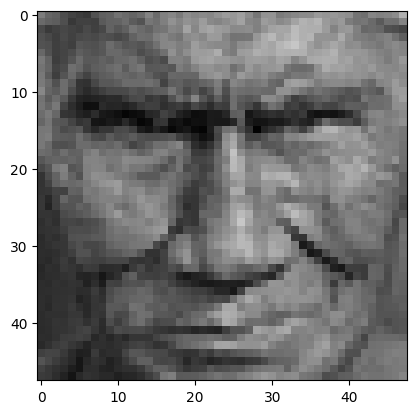

In [5]:
plt.imshow(img_array)

In [6]:
img_array.shape

(48, 48, 3)

In [7]:
#creating .npy file for training data

source_dir = "/content/Data/images/train"
save_dir = "/content/Data/images/norm_train"

for emotion in os.listdir(source_dir):
    emotion_folder = os.path.join(source_dir, emotion)
    save_emotion_folder = os.path.join(save_dir, emotion)

    if os.path.isdir(emotion_folder):
        os.makedirs(save_emotion_folder, exist_ok=True)

        for file in os.listdir(emotion_folder):
            file_path = os.path.join(emotion_folder, file)
            file_name, _ = os.path.splitext(file)
            save_path = os.path.join(save_emotion_folder, file_name + ".npy")

            try:
                with Image.open(file_path) as img:
                    img = img.convert("RGB")
                    img = img.resize((224, 224))
                    pixels = np.array(img, dtype=np.float32) / 255.0
                    pixels = np.transpose(pixels, (2, 0, 1))
                    np.save(save_path, pixels)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")


In [8]:
# creating .csv file for training data

root_dir = "/content/Data/images/norm_train"
csv_path = os.path.join(root_dir, "train.csv")

# Get all emotion folder names (labels)
emotions = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])

# Step 2: Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(emotions)

# print label mapping
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_map)

# Write CSV
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['path', 'label'])

    for emotion in emotions:
        emotion_dir = os.path.join(root_dir, emotion)
        label = label_encoder.transform([emotion])[0]

        for filename in os.listdir(emotion_dir):
            if filename.endswith(".npy"):
                rel_path = os.path.join(emotion, filename)
                writer.writerow([rel_path, label])

print(f"CSV saved at: {csv_path}")


Label Mapping: {np.str_('angry'): np.int64(0), np.str_('disgust'): np.int64(1), np.str_('fear'): np.int64(2), np.str_('happy'): np.int64(3), np.str_('neutral'): np.int64(4), np.str_('sad'): np.int64(5), np.str_('surprise'): np.int64(6)}
CSV saved at: /content/Data/images/norm_train/train.csv


In [9]:
#creating .npy file for validation data
source_dir = "/content/Data/images/validation"
save_dir = "/content/Data/images/norm_validation"

for emotion in os.listdir(source_dir):
    emotion_folder = os.path.join(source_dir, emotion)
    save_emotion_folder = os.path.join(save_dir, emotion)

    if os.path.isdir(emotion_folder):
        os.makedirs(save_emotion_folder, exist_ok=True)

        for file in os.listdir(emotion_folder):
            file_path = os.path.join(emotion_folder, file)
            file_name, _ = os.path.splitext(file)
            save_path = os.path.join(save_emotion_folder, file_name + ".npy")

            try:
                with Image.open(file_path) as img:
                    img = img.convert("RGB")
                    img = img.resize((224, 224))
                    pixels = np.array(img, dtype=np.float32) / 255.0
                    pixels = np.transpose(pixels, (2, 0, 1))
                    np.save(save_path, pixels)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

In [10]:
# Creating .csv file for validation data
root_dir = "/content/Data/images/norm_validation"
csv_path = os.path.join(root_dir, "val.csv")

# Get all emotion folder names (labels)
emotions = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(emotions)

# Print label mapping
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_map)

# Write CSV
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['path', 'label'])  # header

    for emotion in emotions:
        emotion_dir = os.path.join(root_dir, emotion)
        label = label_encoder.transform([emotion])[0]

        for filename in os.listdir(emotion_dir):
            if filename.endswith(".npy"):
                rel_path = os.path.join(emotion, filename)
                writer.writerow([rel_path, label])

print(f"CSV saved at: {csv_path}")

Label Mapping: {np.str_('angry'): np.int64(0), np.str_('disgust'): np.int64(1), np.str_('fear'): np.int64(2), np.str_('happy'): np.int64(3), np.str_('neutral'): np.int64(4), np.str_('sad'): np.int64(5), np.str_('surprise'): np.int64(6)}
CSV saved at: /content/Data/images/norm_validation/val.csv


In [11]:
# Count total number of images
base_path = "Data/images/norm_train"

total_files = 0

for emotion in os.listdir(base_path):
    emotion_path = os.path.join(base_path, emotion)
    if os.path.isdir(emotion_path):
        files = [f for f in os.listdir(emotion_path) if os.path.isfile(os.path.join(emotion_path, f))]
        total_files += len(files)

print(f"Total number of files: {total_files}")


Total number of files: 28821


In [12]:


class EmotionDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        label = int(self.data.iloc[idx, 1])
        image = np.load(img_path)
        image = torch.tensor(image, dtype=torch.float32)

        return image, label


In [13]:
train_dataset = EmotionDataset("/content/Data/images/norm_train/train.csv", "/content/Data/images/norm_train")
val_dataset = EmotionDataset("/content/Data/images/norm_validation/val.csv", "/content/Data/images/norm_validation")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
#Mobilenetv2
# class EmotionMobileNetV2(nn.Module):
#     def __init__(self, num_classes=7):
#         super(EmotionMobileNetV2, self).__init__()

#         # Load pretrained MobileNetV2
#         self.base_model = models.mobilenet_v2(pretrained=True)

#         # Freeze all layers initially
#         for param in self.base_model.features.parameters():
#             param.requires_grad = False

#         # Remove original classifier
#         self.base_model.classifier = nn.Identity()

#         # Custom classification head with Dropout
#         self.custom_classifier = nn.Sequential(
#             nn.Linear(1280, 128),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(64, num_classes)       # No softmax needed
#         )

#     def forward(self, x):
#         x = self.base_model(x)
#         x = self.custom_classifier(x)
#         return x


In [15]:
class EmotionEfficientNetB0(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionEfficientNetB0, self).__init__()

        # Load pretrained EfficientNet-B0
        self.base_model = models.efficientnet_b0(pretrained=True)


        for param in self.base_model.features.parameters():
            param.requires_grad = False


        self.base_model.classifier = nn.Identity()

        self.custom_classifier = nn.Sequential(
            nn.Linear(1280, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.custom_classifier(x)
        return x


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch.nn as nn

targets = [label for _, label in train_dataset]

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(targets), y=targets)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)


In [18]:
model=EmotionEfficientNetB0(num_classes=7).to(device)
# #criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', patience=3, factor=0.5, verbose=True
# )

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)

best_acc = 0
early_stop_counter = 0
history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 160MB/s]


In [19]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [22]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    accuracy = total_correct / len(loader.dataset)
    return total_loss / len(loader), accuracy

In [23]:
def validate_one_epoch(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / total
    accuracy = correct / total

    return avg_loss, accuracy


In [24]:
def unfreeze_mobilenet(model):
    for param in model.base_model.features[5:].parameters():
        param.requires_grad = True


In [ ]:

patience=3
patience_counter=0

for epoch in range(1, 51):
    if epoch == 10:
      unfreeze_mobilenet(model)
      print("✅ Unfroze last few layers of MobileNetV2")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion)
    scheduler.step(val_loss)



    print(f"Epoch {epoch} | Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    if val_acc > best_acc:
      best_acc = val_acc
      patience_counter = 0
      torch.save(model.state_dict(), f"best.pt")
    else:
      patience_counter += 1
      if patience_counter >= patience:
          print("Early stopping triggered")
          break





histories = deepcopy(history)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1 | Train Acc: 0.2256, Val Acc: 0.3755
Epoch 2 | Train Acc: 0.3215, Val Acc: 0.3429
Epoch 3 | Train Acc: 0.3571, Val Acc: 0.3965
Epoch 4 | Train Acc: 0.3773, Val Acc: 0.4329
Epoch 5 | Train Acc: 0.3970, Val Acc: 0.4319
Epoch 6 | Train Acc: 0.4106, Val Acc: 0.4232
Epoch 7 | Train Acc: 0.4252, Val Acc: 0.4357
Epoch 8 | Train Acc: 0.4357, Val Acc: 0.4550
Epoch 9 | Train Acc: 0.4422, Val Acc: 0.4498
✅ Unfroze last few layers of MobileNetV2
Epoch 10 | Train Acc: 0.4777, Val Acc: 0.5327
Epoch 11 | Train Acc: 0.5585, Val Acc: 0.5944
Epoch 12 | Train Acc: 0.5963, Val Acc: 0.5996
Epoch 13 | Train Acc: 0.6155, Val Acc: 0.6131
Epoch 14 | Train Acc: 0.6335, Val Acc: 0.6190


In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(histories['train_acc'], label=f'Train Acc')
plt.plot(histories['val_acc'], label=f'Val Acc')
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(histories['train_loss'], label=f'Train Loss')
plt.plot(histories['val_loss'], label=f'Val Loss')
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()
